# RL homework 1
**Due date: March 2nd, 2021, 11am**

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

Name: Sahil Shah

Student number: 20194624

**How to submit**

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`studentnumber_RL_hw1.ipynb`** before the deadline above.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms (without running experiments or extensive calculations)

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [1]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#009988', '#0033ff', '#993388', '#ee6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=50,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1
**[8 pts]** Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):

  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self.arm_count = np.zeros(number_of_arms)
    self.q_values = np.zeros(number_of_arms)
    self._number_of_steps_so_far = 0
    self.c = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is None:
      pass
    else:
      # Update statistics
      self.arm_count[previous_action] += 1
      step_size = 1/self.arm_count[previous_action]
      self.q_values[previous_action] += step_size*(reward -  self.q_values[previous_action])
      
    # Get new action
    self._number_of_steps_so_far += 1
    new_action = np.argmax(self.q_values + self.c*np.sqrt(np.log(self._number_of_steps_so_far)/self.arm_count))
    return new_action


  def reset(self):
    "Set all statistics to zero"
    self.arm_count = np.zeros(number_of_arms)
    self.q_values = np.zeros(number_of_arms)
    self._number_of_steps_so_far = 0

## Q2
**[8 pts]** Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):

  def __init__(self, name, number_of_arms, epsilon):
    self.name = name
    self._number_of_arms = number_of_arms
    self.arm_count = np.zeros(number_of_arms)
    self.q_values = np.zeros(number_of_arms)
    self._number_of_steps_so_far = 0
    self.epsilon = epsilon
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is None:
      pass
    else:
      # Update statistics
      self.arm_count[previous_action] += 1
      step_size = 1/self.arm_count[previous_action]
      self.q_values[previous_action] += step_size*(reward -  self.q_values[previous_action])
    p = np.random.random()
    self._number_of_steps_so_far += 1

    if callable(self.epsilon):
      if p < 1-self.epsilon(self._number_of_steps_so_far):
        max_action_values = [i for i in range(self._number_of_arms)
                           if self.q_values[i] == np.max(self.q_values)]
        new_action = np.random.choice(max_action_values)
      else:
        new_action = np.random.randint(self._number_of_arms)
    else:
      if p < 1-self.epsilon:
        max_action_values = [i for i in range(self._number_of_arms)
                           if self.q_values[i] == np.max(self.q_values)]
        new_action = np.random.choice(max_action_values)
      else:
        new_action = np.random.randint(self._number_of_arms)
    return new_action
  def reset(self):
    self.arm_count = np.zeros(number_of_arms)
    self.q_values = np.zeros(number_of_arms)
    self._number_of_steps_so_far = 0

## Q3
**[12 pts]** Implement a softmax REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
class REINFORCE(object):

  def __init__(self, name, number_of_arms, step_size, baseline):
    self._number_of_arms = number_of_arms
    self.name = name
    self.step_size = step_size
    self.baseline = baseline
    self._number_of_steps_so_far = 0
    self.av_reward = 0
    self.preferences = np.ones(number_of_arms)/number_of_arms
    self.policy = (self.preferences**2)/np.sum(self.preferences**2)
    self.reset()

  def step(self, previous_action, reward):
    self._number_of_steps_so_far += 1
    if previous_action is None:
      pass
    else:
      if self.baseline:
        self.av_reward += (reward - self.av_reward)/self._number_of_steps_so_far
        reward -= self.av_reward
      # Update statistics
      for i in range(self._number_of_arms):
        if i == previous_action:
          self.preferences[i] += self.step_size * reward * (2*((1/self.preferences[i]) - self.preferences[i]/np.sum(self.preferences**2)))
        else:
          self.preferences[i] -= self.step_size * reward * (2*self.preferences[i]/np.sum(self.preferences**2))

      self.policy = [(self.preferences[i]**2/np.sum(self.preferences**2)) for i in range(self._number_of_arms)]

    new_action = np.random.choice(np.arange(self._number_of_arms), p=self.policy)
    return new_action
      

  def reset(self):
    self._number_of_steps_so_far = 0
    self.preferences = np.ones(self._number_of_arms)/self._number_of_arms
    self.policy = (self.preferences**2)/np.sum(self.preferences**2)
    self.av_reward = 0

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE without baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


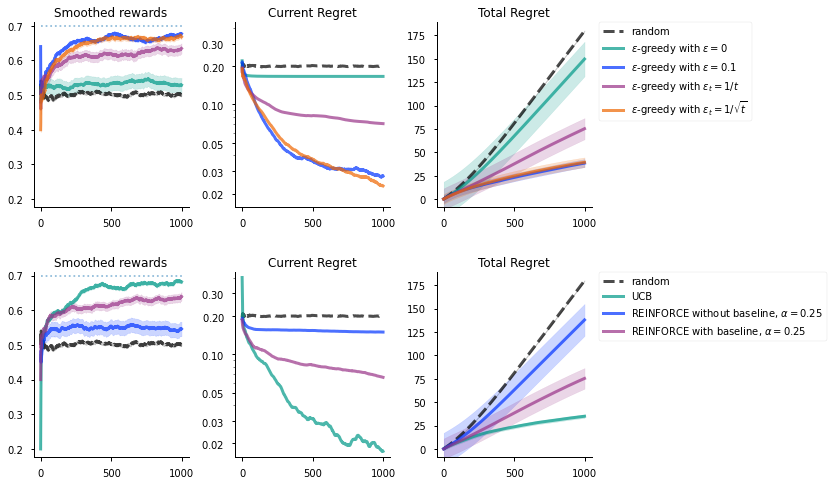

In [10]:
experiment1.show()

## Q5
(Answer inline in the markdown below each question, **within this text cell**.)

**[5pts]** For the best two algorithms from the above plots, explain whether
we would in general expect this algorithm to do well, and why.

We would in general expect UCB to perform well as it targets the action with the highest probability at a high reward (potentially with high uncertainty) and explores until it can be certain of the action values of the best actions and so values exploration more so than the other algorithms. 

The $\epsilon$-greedy with $\epsilon_t = 1/t^{0.5}$ gives the next best algorithm and this is again due to its focus given to exploration over exploitation, which decreases over time but at a slower rate than the $\epsilon$-greedy with $\epsilon_t = 1/t$ algorithm and reduces exploration once we are close to the optimal action-values compared to the $\epsilon_t = 0.1$ algorithm, which maintains the same amount of exploration regardless of the number of steps. 

**[5pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms.

The $\epsilon$-greedy with $\epsilon_t = 1/t^{0.5}$ has the lowest total regret, followed by $\epsilon_t = 0.1$, then $\epsilon_t = 1/t$ and finally $\epsilon_t = 0$. The algorithm with $\epsilon_t = 0$ is purely greedy and because there are no negative rewards, the same action is chosen continuously and so it is expected to be the worst as there is no exploration and it follows exploitation. 

As explained in the previous question, the $\epsilon_t = 1/t^{0.5}$ algorithm gives the lowest total regret due to the slower decay of exploration compared to the $\epsilon_t = 1/t$ algorithm and reduced exploration once we are close to the optimal action-values, which is not possible in the $\epsilon_t = 0.1$ algorithm. 

Finally the $\epsilon_t = 0.1$ algorithm performs better than the $\epsilon_t = 1/t$ algorithm due to its greater focus on exploration, as the value of $\epsilon_t$ decays quickly in the latter algorithm at a high number of timesteps.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [11]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


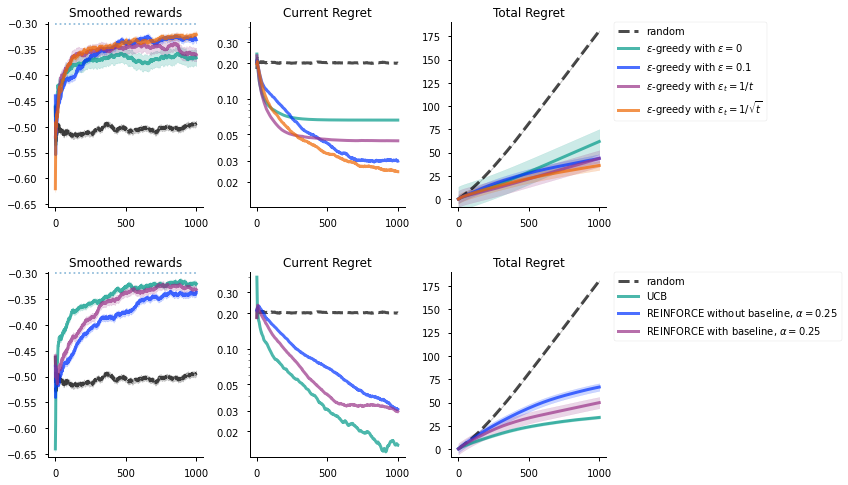

In [12]:
experiment2.show()

## Q6
**[8pts]** For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

The random algorithm did not change and this was to be expected, as in this case actions are chosen randomly regardless of rewards and previous actions.

The $\epsilon$-greedy with $\epsilon_t = 0$ improved its performance significantly compared to **experiment 1** and this was to be expected as the implementation of negative rewards for failure and no reward for success meant that the same action was not chosen each timestep.

The $\epsilon$-greedy with $\epsilon_t = 0.1$ did slightly improve its performance compared with **experiment 1**. This was again due to the negative rewards encouraging more exploration following actions leading to failure.

The $\epsilon$-greedy with $\epsilon_t = 1/t$ did not improve its performance significantly compared with **experiment 1** and this was due to the high level exploration present in the algorithm initially before becoming predominantly greedy at higher timesteps.

The $\epsilon$-greedy with $\epsilon_t = 1/t^{0.5}$ did not change its performance significantly compared with **experiment 1**. This was due to the high level of exploration already in existence within the algorithm.

The REINFORCE without baseline did improve its performance significantly compared with **experiment 1** because the negative rewards resulted in negative updates to the preferences, meaning exploration was preferred and other actions were chosen, which minimised total regret.

The REINFORCE with baseline did not change its performance significantly compared with **experiment 1**, because the average reward was negative and so the difference between the reward and average reward is quite small, so the increase in exploration is minimal and little improvement is observed in the total regret.

The UCB algorithm's performance did not change significantly as the algorithm selects the action which is most likely to give the highest reward, until it can be more certain of the action values for different actions. Changing the rewards from +1 and 0 to 0 and -1 should have little impact on which action is selected for this algorithm.

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.25$",
        number_of_arms,
        step_size=0.25,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [14]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


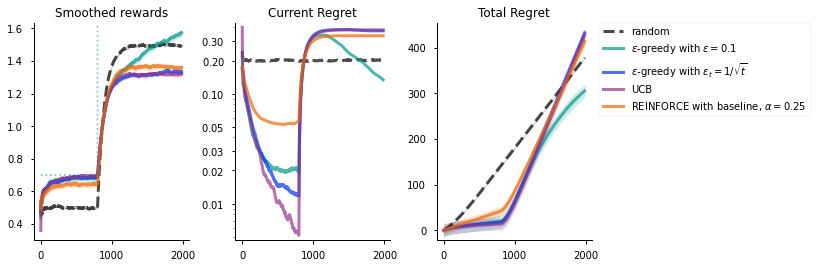

In [15]:
experiment3.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


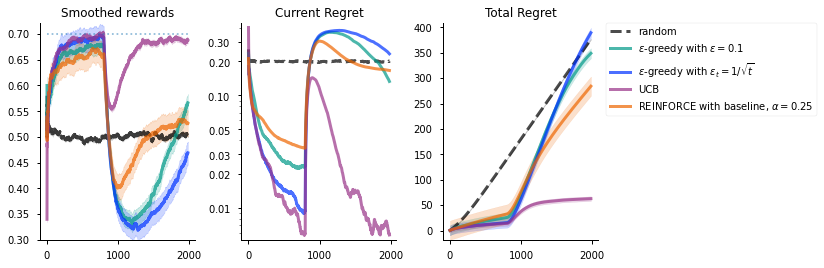

In [16]:
experiment4.show()

## Q7

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

**[8 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

At around 800 steps, all the algorithms are close to their optimal policies and so do not deviate from this when the rewards change, as they will not explore much and are still receiving a reward of +1 for success, despite the change in reward from 0 to +2 for failure. The $\epsilon$-greedy with $\epsilon_t = 0.1$ does continue to explore after 800 steps and so is the only algorithm that is able to reduce its current regret.

**[8 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

This time the rewards flip to being 0 for success and +1 for failure after 800 steps and the algorithms receive 0 reward with their policies and must quickly relearn new policies. Since UCB was the fastest to learn initially, it makes sense that it is the fastest to relearn and since the number of steps is very high now, it makes sense that the $\epsilon$-greedy with $\epsilon_t = 1/t^{0.5}$ is the slowest to relearn, as this algorithm is now almost greedy for the previous action that gave a reward of +1. The $\epsilon$-greedy with $\epsilon_t = 0.1$ is the second fastest as it relearns through its constant amount of exploration, whereas the REINFORCE with baseline algorithm relearns the third fastest and learns at a slightly slower speed than initially, as at a high number of steps the updates to the average reward and therefore preferences will be smaller. 

**[4 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

In **experiment 3**, the UCB current regret curve remains flat at a high regret after 800 steps, whereas in **experiment 4** the UCB current regret curve reduces its regret after 800 steps, after an initial increase in regret upon the change in rewards. This is because of the change in rewards as in **experiment 3**, the reward for success does not change and so the same action is chosen that was originally optimal, resulting in a constant level of high regret following the reward change. However in **experiment 4**, the rewards flip and so the UCB algorithm must relearn the action-values with greater uncertainty for the actions and so the regret decreases again following the initial increase upon the rewards change.

**[4 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify the $\epsilon$-greedy algorithm implemented above to deal with that better?  Be specific and concise.

In the $\epsilon$-greedy algorithm, the calculation of the step size is inversely proportional to the number of counts of the arm of the previous action and following many repeated actions, the step size tends to zero, which means the updates tend to zero and exploration becomes very limited. Therefore with non-stationary rewards, it is important to maintain a certain level of exploration since a single action will not continuously provide the optimal reward. Another way to modify the $\epsilon$-greedy algorithm would be to use a discounted average reward when updating action values, to ensure greater weight would be given to more recent rewards, as they will be most in common with the current state of non-stationary rewards.

**[8 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

Again, a way to ensure there would be a certain level of exploration would be to use a constant step size when updating the action values. Another method would be to use a discounted empirical average of rewards when updating action values to ensure greater weight would be given to more recent rewards, as they will be most in common with the current state of non-stationary rewards. A final method could be to use a window sliding mechanism when updating action values, to ensure that only the $\tau$ most recent rewards are used, as again these will most likely correspond to the current state of non-stationary rewards. 

# C) Reasoning about algorithms

## Q8

Consider the UCB algorithm. Suppose we have two actions, $a$ and $b$. Consider the initial exploration bonus for each to be infinite, as long as we have not selected the corresponding action, so that the algorithm first selects each action at least once.

Suppose action $a$ yields a Bernoulli random reward with $p(R=1 \mid a) = 1/3$ and $p(R=0 \mid a) = 2/3$.  Action $b$ also yields a Bernoulli random reward, but with $p(R=1 \mid b) = 2/3$ and $p(R=0 \mid b) = 1/3$.

**[7 pts]** What is the probability (before seeing any data) of selecting action $a$ on the third time step (at which point we will have selected both $a$ and $b$ exactly once)?  (Break ties uniformly, if relevant.)

Either action $a$ or $b$ can be selected first with probability $1/2$. If action $a$ is selected first, then $b$ must be selected second due to the infinite exploration bonus and vice versa. If action $a$ is selected first followed by action $b$, the following probabilities probabilities of selecting action $a$ on the third timestep, $p(a)$ are:

- Action $a$ gives reward 1 and Action $b$ gives reward 0, then the probability of this sequence is $1/9$ and $p(a) = 1$
- Action $a$ gives reward 0 and Action $b$ gives reward 1, then the probability of this sequence is $4/9$ and $p(a) = 0$
- Action $a$ gives reward 0 and Action $b$ gives reward 0, then the probability of this sequence is $2/9$ and $p(a) = 0.5$
- Action $a$ gives reward 1 and Action $b$ gives reward 1, then the probability of this sequence is $2/9$ and $p(a) = 0.5$

The same probabilities occur if action $b$ is selected first, followed by $a$. Therefore, by multiplying each of the $p(a)$ probabilities by the probabilities of those sequences occurring and summing over them, the probability of selecting action $a$ is $1/3$. 

## Q9

Consider a bandit with two arms, $a$ and $b$.  So far, we have seen the following actions and rewards, on time steps $t=1$ and $t=2$:
\begin{align*}
t=1\,:\qquad A_1=a~,~ R_1=0\\
t=2\,:\qquad A_2=b~,~ R_2=1 
\end{align*}
The rewards are known to be Bernoulli random variables (so $R_t \in \{0, 1\}$) with unknown means.

Consider a Thompson sampling algorithm to select actions, with a uniform Beta prior at time $t=0$ such that the probability density functions for the expected reward for both actions before seeing any data (at time $t=0$) are defined by $p(E[R] = x\mid a) = 1$, for all $x\in[0,1]$, and all $a$.


**[7 pts]** What is the probability under Thompson sampling of $A_3 = a$? Show your calculations, but keep it concise.

From the above, it can be seen that the variable X ~ Beta(1,2) and Y ~ Beta(2,1). Therefore $P(X=x) = 2(1-x)$ and $P(Y=y) = 2y$.

Therefore the probability X > Y is:

$P(X>Y) = \int_0^1 \int_0^1 P(X = x)P(Y = y)I(x>y) dy dx$

$P(X>Y) = \int_0^1 \int_0^x P(X = x)P(Y = y) dy dx$

$P(X>Y) = \int_0^1 \int_0^x 4(1-x)y dy dx$

$P(X>Y) = \int_0^1 2(1-x)x^2 dx$

$P(X>Y) = \int_0^1 2x^2-2x^3 dx = [\frac{2x^3}{3}-\frac{x^4}{2}]_0^1 = \frac{1}{6}$

Therefore, it can be seen that the probability that $A_3 = a$ is $\frac{1}{6}$.

## Q10

Consider a tabular ergodic MDP, and consider the following algorithm: 

On each time step $t$ we use UCB in the state we are currently in to determine the action to take.  Specifically, use and update the required statistics for UCB locally, for that state. In other words, in each state we update the UCB statistics as if that state is a bandit problem. 

However, instead of averaging the immediate rewards to use as action values, we use one-step Q-learning with a step size $\alpha_t$ to predict action values with some discount $\gamma \in [0, 1]$.

**[8 pts]** Is this algorithm guaranteed to converge to the optimal value function $q_*$ (for any finite MDP with well-defined values, e.g., $\gamma<1$) for an appropriately chosen step size schedule $\{ \alpha_t \}_{t=0}^\infty$?  Prove your answer, but be concise.  (E.g., this proof should not include lengthy calculations, you don't have to specify a concrete step size schedule, etc.)

For a finite MDP, the Q-learning algorithm is given by the following update rule:

$Q_{t+1}(x_t,a_t) = Q_t(x_t,a_t) + \alpha_t(x_t,a_t)[r_t + \gamma \max_bQ_t(x_t,b)-Q_t(x_t,a_t)]$

This Q-Learning update rule converges with probability 1 to the optimal Q-function provided that: $\sum_t\alpha_t(x,a) = \infty$ and $\sum_t\alpha_t^2(x,a) < \infty$ for all states $x$ and actions $a$. Since $0 ≤ α_t(x, a) < 1$, the above equality and inequality require that all state-action pairs
be visited infinitely often. The convergence can be shown in the following proof:

If we define: $\Delta_t = Q_t(x,a) - Q^*(x,a)$

$\Delta_t$ will converge to zero with probability 1 if the following assumptions are met:

- $0\leq\alpha_t\leq1$, $\sum_t\alpha_t(x) = \infty$ and $\sum_t\alpha_t^2(x) < \infty$
- $||\mathbb{E}[F_t(x,a) |\mathscr{F_t}]||_W \leq \gamma||\Delta_t||_W$, with $\gamma < 1$
- $\textbf{Var}[F_t(x,a) |\mathscr{F_t}] \leq C(1+||\Delta_t||_W^2)$, for $C > 0$

Then: $\Delta_t(x_t,a_t) = (1-\alpha_t(x_t,a_t))\Delta_t(x_t,a_t)+\alpha_t(x_t,a_t)[r_t + \gamma \max_bQ_t(x_{t+1},b)-Q_t(x_t,a_t)]$

If we also define: $F_t(x,a) = r(x,a,X(x,a) + \gamma \max_bQ_t(x_t,b)-Q_t(x_t,a_t)$, where $X(x,a)$ is a random sample state obtained from the Markov chain, then $\mathbb{E}[F_t(x,a) |\mathscr{F_t}]$ can be simplified to:

$\mathbb{E}[F_t(x,a) |\mathscr{F_t}) = (\textbf{H}Q_t)(x,a) - (\textbf{H}Q^*)(x,a)$

Where $\textbf{H}$ is the contraction operator and \mathscr{F_t} is the hypothesis space. Using the inequality $||\textbf{H}q_1 - \textbf{H}q_2||_\infty \leq \gamma||q_1-q_2||_\infty$, it can be shown that:

$||\mathbb{E}[F_t(x,a) |\mathscr{F_t}]||_\infty \leq \gamma||Q_t-Q^*||_\infty = \gamma||\Delta_t||_\infty$

It can then be shown that $\textbf{Var}[F_t(x,a) |\mathscr{F_t}] \leq C(1+||\Delta_t||_W^2)$, for some constant $C$ as $r$ is bounded.

It can then be deduced that $\Delta_t$ converges to zero as all of the above conditions have been met and thus $Q_t$ converges to $Q^*$ with probability 1.